腦部腫瘤分類（Pytorch）Resnet18版本

準備動作（導入模組）

In [1]:
!pip install torchsummary
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary

from sklearn.metrics import accuracy_score,classification_report

import pandas as pd
from tqdm import tqdm_notebook as tqdm
import time
import warnings
from collections import OrderedDict
warnings.simplefilter("ignore")

You should consider upgrading via the 'C:\Users\marti\anaconda3\python.exe -m pip install --upgrade pip' command.


下載模型/預設GPU

In [2]:
# download the pretrained model
import torchvision.models as models
model = models.resnet18(pretrained = True)

In [3]:
trainig_path = 'data/Training'
testing_path = 'data/Testing'

IMAGE_SIZE=(128,128)
batch_size=64
learning_rate = 0.0008
epochs=50
num_classes=4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

定義數據集處理的方法

In [4]:
def images_transforms(phase):
    if phase == 'training':
        data_transformation = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
#             transforms.RandomEqualize(10),
            transforms.RandomRotation(degrees=(-25,20)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        data_transformation=transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])

    return data_transformation

從訓練集中讀取醫療影像數據

In [5]:
trainset=datasets.ImageFolder(trainig_path,transform=images_transforms('training'))
testset=datasets.ImageFolder(testing_path,transform=images_transforms('test'))
testset, valset = torch.utils.data.random_split(testset, [150, 244])

取得各病徵編號

In [6]:
print(trainset.class_to_idx)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


加載醫療影像，一個批次64筆資料，且打亂順序

In [7]:
train_loader = DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
test_loader = DataLoader(testset,batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)

輸出樣本，隨機列出訓練集中的醫療影像

In [8]:
def imshow(img):
    plt.figure(figsize=(20, 20))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


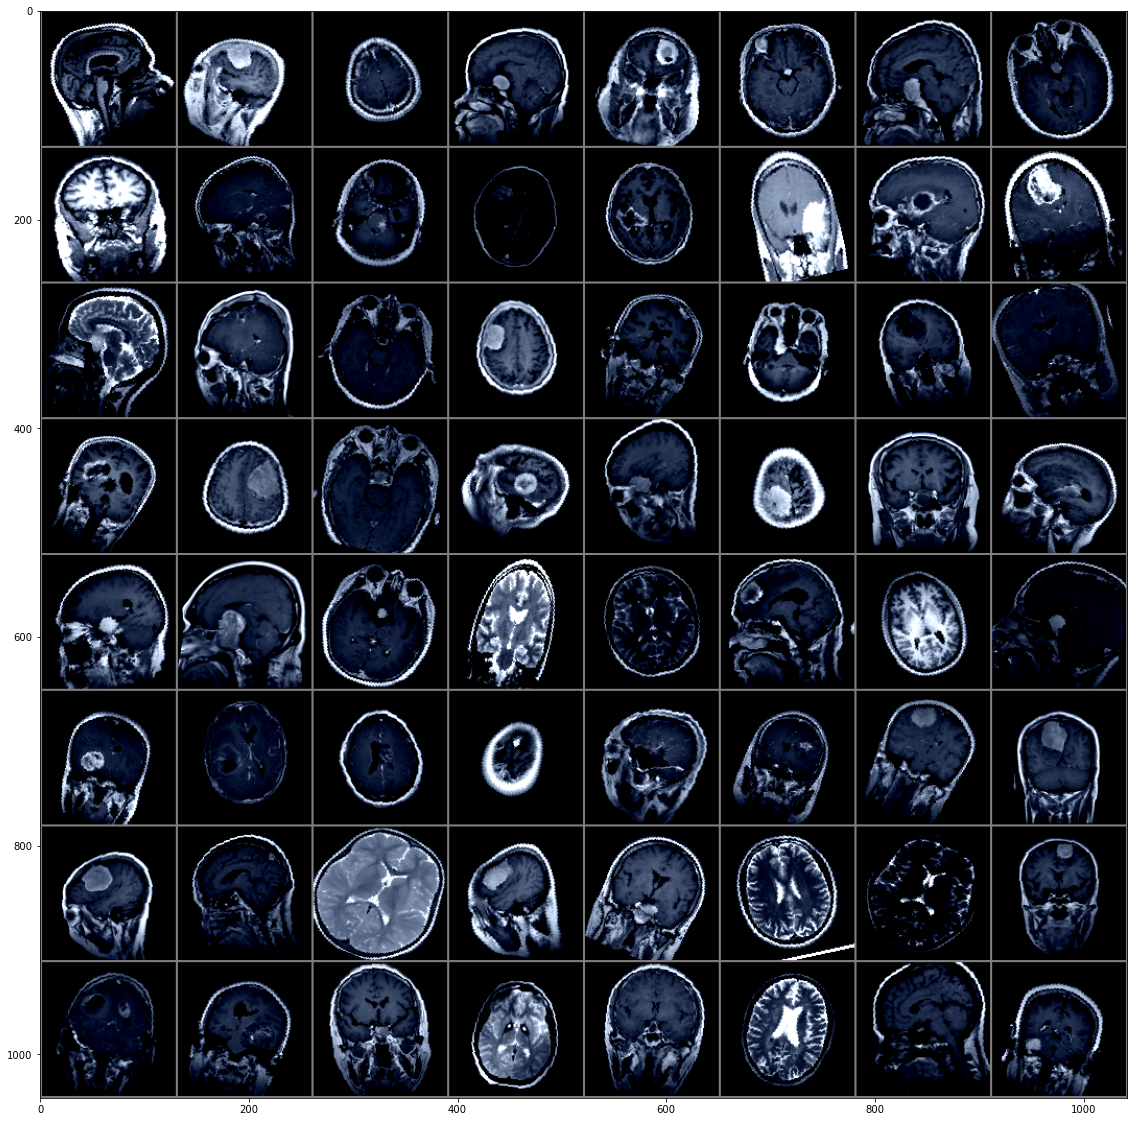

In [9]:
examples = iter(train_loader)
images,labels = examples.next()
imshow(torchvision.utils.make_grid(images))

預設只訓練分類器

In [10]:
# Freeze the parameters
for param in model.parameters():
    param.requires_grad = False

建構神經網路的模型

In [11]:
#Classifier architecture to put on top of resnet18
input = model.fc.in_features
model.fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(input,1024)),
    ('relu1', nn.ReLU(inplace=True)),
    ('fc2', nn.Linear(1024,2048)),
    ('relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(2048,num_classes)),
]))

In [12]:
#shifting model to gpu
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),lr=learning_rate)

模型可視化

In [13]:
IMAGE_SIZE=(3,)+IMAGE_SIZE
print(summary(model,IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

訓練模型，并印出損失函數

In [14]:
def test(model,testloader):
    with torch.no_grad():
        n_correct=0
        n_samples=0
        y_pred=[]
        y_actual=[]
        model.eval()
        for i,(images,labels) in enumerate(testloader):
            images=images.to(device)
            labels=labels.to(device)

            outputs=model(images)

            y_actual+=list(np.array(labels.detach().to('cpu')).flatten())
        # value ,index
            predictes=torch.max(outputs,1)[1]
            y_pred+=list(np.array(predictes.detach().to('cpu')).flatten())
        # number of samples in current batch
            n_samples+=labels.shape[0]

            n_correct+= (predictes==labels).sum().item()

        y_actual=np.array(y_actual).flatten()
        y_pred=np.array(y_pred).flatten()
        return y_actual,y_pred

def train(model,train_loader,criterion,optimizer,val_loader,epochs=25):
    train_losses = []
    val_losses = []
    train_auc = []
    val_auc = []
    train_auc_epoch = []
    val_auc_epoch = []
    best_acc = 0.0
    # np.inf 表示+∞，是没有確切的數值的,類型為浮點數
    min_loss = np.Inf

    since = time.time()
    for e in range(epochs):
        y_actual=[]
        y_pred=[]
        train_loss = 0.0
        val_loss = 0.0

        # Train the model
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy
            train_loss += loss.item()

            predictes = torch.max(outputs,1)[1]
            y_actual += list(labels.data.cpu().numpy().flatten())
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        train_auc.append(accuracy_score(y_actual, y_pred))

        # Evaluate the model
        model.eval()
        for i, (images, labels) in enumerate(tqdm(val_loader, total=int(len(val_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Loss and accuracy
            val_loss += loss.item()
            predictes=torch.max(outputs,1)[1]
            y_actual += list(labels.data.cpu().numpy().flatten())
            y_pred += list(predictes.detach().cpu().numpy().flatten())

        val_auc.append(accuracy_score(y_actual, y_pred))

        # Average losses and accuracies
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        training_auc = train_auc[-1]
        validation_auc = val_auc[-1]
        train_auc_epoch.append(training_auc)
        val_auc_epoch.append(validation_auc)

        # Updating best validation accuracy
        if best_acc < validation_auc:
            best_acc = validation_auc

        # Saving best model
        if min_loss >= val_loss:
            torch.save(model.state_dict(), 'model\\resnet-18.pt')
            min_loss = val_loss

        print('EPOCH {}/{} Train loss: {:.6f},Validation loss: {:.6f}, Train AUC: {:.4f}  Validation AUC: {:.4f}\n  '.format(e+1, epochs,train_loss,val_loss, training_auc,validation_auc))
        print('-' * 10)
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))
    return train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch

In [15]:
train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch=train(model,train_loader,criterion,optimizer,val_loader,epochs)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 1/50 Train loss: 0.898898,Validation loss: 1.824238, Train AUC: 0.6328  Validation AUC: 0.6108
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 2/50 Train loss: 0.580508,Validation loss: 1.439983, Train AUC: 0.7582  Validation AUC: 0.7412
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 3/50 Train loss: 0.530711,Validation loss: 1.598171, Train AUC: 0.7871  Validation AUC: 0.7662
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 4/50 Train loss: 0.466532,Validation loss: 1.899715, Train AUC: 0.8174  Validation AUC: 0.7925
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 5/50 Train loss: 0.467164,Validation loss: 1.499305, Train AUC: 0.8188  Validation AUC: 0.8006
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 6/50 Train loss: 0.412584,Validation loss: 1.521257, Train AUC: 0.8376  Validation AUC: 0.8154
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 7/50 Train loss: 0.399058,Validation loss: 1.471351, Train AUC: 0.8443  Validation AUC: 0.8250
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 8/50 Train loss: 0.372803,Validation loss: 1.653162, Train AUC: 0.8596  Validation AUC: 0.8391
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 9/50 Train loss: 0.391607,Validation loss: 1.551250, Train AUC: 0.8422  Validation AUC: 0.8231
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 10/50 Train loss: 0.351762,Validation loss: 1.548445, Train AUC: 0.8599  Validation AUC: 0.8401
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 11/50 Train loss: 0.323190,Validation loss: 1.672047, Train AUC: 0.8732  Validation AUC: 0.8507
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 12/50 Train loss: 0.332278,Validation loss: 1.444233, Train AUC: 0.8676  Validation AUC: 0.8500
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 13/50 Train loss: 0.295767,Validation loss: 1.841034, Train AUC: 0.8895  Validation AUC: 0.8654
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 14/50 Train loss: 0.268471,Validation loss: 1.551605, Train AUC: 0.8997  Validation AUC: 0.8780
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 15/50 Train loss: 0.278702,Validation loss: 1.718848, Train AUC: 0.8902  Validation AUC: 0.8699
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 16/50 Train loss: 0.278109,Validation loss: 1.662045, Train AUC: 0.8882  Validation AUC: 0.8703
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 17/50 Train loss: 0.251485,Validation loss: 1.709456, Train AUC: 0.9038  Validation AUC: 0.8879
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 18/50 Train loss: 0.253045,Validation loss: 1.447175, Train AUC: 0.9014  Validation AUC: 0.8860
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 19/50 Train loss: 0.249727,Validation loss: 1.700234, Train AUC: 0.9063  Validation AUC: 0.8889
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 20/50 Train loss: 0.238298,Validation loss: 1.625304, Train AUC: 0.9111  Validation AUC: 0.8950
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 21/50 Train loss: 0.214195,Validation loss: 1.611646, Train AUC: 0.9216  Validation AUC: 0.9056
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 22/50 Train loss: 0.197157,Validation loss: 1.750110, Train AUC: 0.9272  Validation AUC: 0.9101
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 23/50 Train loss: 0.234009,Validation loss: 1.756576, Train AUC: 0.9073  Validation AUC: 0.8892
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 24/50 Train loss: 0.211958,Validation loss: 1.688159, Train AUC: 0.9178  Validation AUC: 0.9008
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 25/50 Train loss: 0.181771,Validation loss: 1.917541, Train AUC: 0.9272  Validation AUC: 0.9082
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 26/50 Train loss: 0.187451,Validation loss: 1.635540, Train AUC: 0.9220  Validation AUC: 0.9053
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 27/50 Train loss: 0.176973,Validation loss: 2.211957, Train AUC: 0.9300  Validation AUC: 0.9088
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 28/50 Train loss: 0.188635,Validation loss: 1.971858, Train AUC: 0.9303  Validation AUC: 0.9123
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 29/50 Train loss: 0.167797,Validation loss: 1.709875, Train AUC: 0.9373  Validation AUC: 0.9184
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 30/50 Train loss: 0.161575,Validation loss: 1.774505, Train AUC: 0.9376  Validation AUC: 0.9210
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 31/50 Train loss: 0.174792,Validation loss: 2.124753, Train AUC: 0.9324  Validation AUC: 0.9123
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 32/50 Train loss: 0.154331,Validation loss: 1.773461, Train AUC: 0.9470  Validation AUC: 0.9300
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 33/50 Train loss: 0.154603,Validation loss: 1.641178, Train AUC: 0.9481  Validation AUC: 0.9316
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 34/50 Train loss: 0.159777,Validation loss: 1.897864, Train AUC: 0.9411  Validation AUC: 0.9213
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 35/50 Train loss: 0.159779,Validation loss: 1.810071, Train AUC: 0.9408  Validation AUC: 0.9226
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 36/50 Train loss: 0.140291,Validation loss: 2.059261, Train AUC: 0.9453  Validation AUC: 0.9281
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 37/50 Train loss: 0.152329,Validation loss: 1.980306, Train AUC: 0.9415  Validation AUC: 0.9258
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 38/50 Train loss: 0.132278,Validation loss: 1.899872, Train AUC: 0.9488  Validation AUC: 0.9326
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 39/50 Train loss: 0.136810,Validation loss: 1.663644, Train AUC: 0.9502  Validation AUC: 0.9316
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 40/50 Train loss: 0.130078,Validation loss: 1.841850, Train AUC: 0.9509  Validation AUC: 0.9355
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 41/50 Train loss: 0.134155,Validation loss: 1.910651, Train AUC: 0.9474  Validation AUC: 0.9306
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 42/50 Train loss: 0.123332,Validation loss: 2.221127, Train AUC: 0.9523  Validation AUC: 0.9342
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 43/50 Train loss: 0.119841,Validation loss: 2.271031, Train AUC: 0.9544  Validation AUC: 0.9367
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 44/50 Train loss: 0.121838,Validation loss: 2.249244, Train AUC: 0.9554  Validation AUC: 0.9383
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 45/50 Train loss: 0.136028,Validation loss: 1.722187, Train AUC: 0.9467  Validation AUC: 0.9338
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 46/50 Train loss: 0.112448,Validation loss: 1.812505, Train AUC: 0.9571  Validation AUC: 0.9412
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 47/50 Train loss: 0.109945,Validation loss: 2.253306, Train AUC: 0.9599  Validation AUC: 0.9432
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 48/50 Train loss: 0.106507,Validation loss: 2.024704, Train AUC: 0.9617  Validation AUC: 0.9467
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 49/50 Train loss: 0.106655,Validation loss: 2.224035, Train AUC: 0.9631  Validation AUC: 0.9480
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 50/50 Train loss: 0.118928,Validation loss: 1.894292, Train AUC: 0.9568  Validation AUC: 0.9438
  
----------
Training completed in 28m 19s
Best validation accuracy: 0.947977


In [16]:
#model.load_state_dict(torch.load('model/resnet-18.pt'))
y_actual,y_pred = test(model,test_loader)
acc = classification_report(y_actual,y_pred,target_names=trainset.classes)
df = pd.DataFrame(classification_report(y_actual,y_pred,target_names=trainset.classes, output_dict=True)).transpose()
df.to_csv("outputs\\resnet18_result.csv", index= True)
print(f"{acc}")

                  precision    recall  f1-score   support

    glioma_tumor       0.56      0.14      0.22        36
meningioma_tumor       0.70      0.96      0.81        45
        no_tumor       0.70      0.93      0.80        43
 pituitary_tumor       1.00      0.88      0.94        26

        accuracy                           0.74       150
       macro avg       0.74      0.73      0.69       150
    weighted avg       0.72      0.74      0.69       150



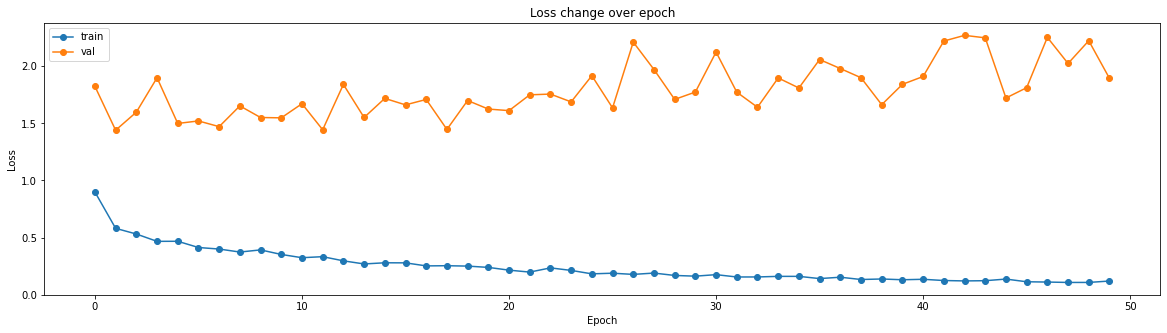

In [17]:
plt.figure(figsize=(20,5))
plt.plot(train_losses, '-o', label="train")
plt.plot(val_losses, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss change over epoch")
plt.legend()
plt.savefig('outputs\loss_resnet18.jpg')

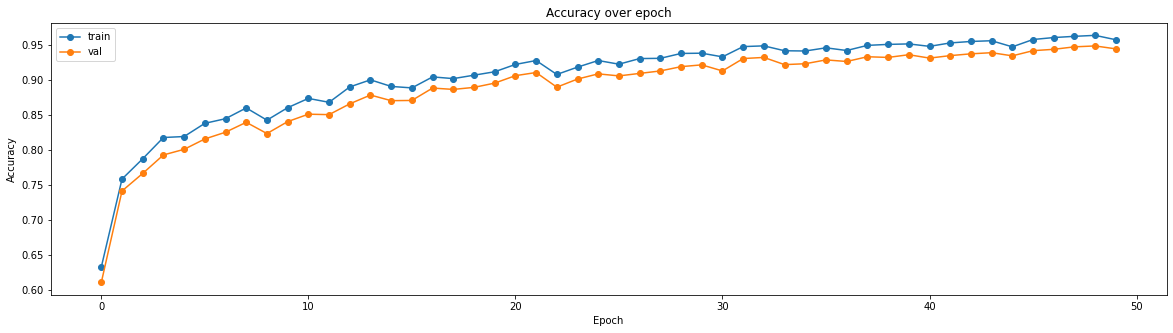

In [18]:
plt.figure(figsize=(20,5))
plt.plot(train_auc_epoch, '-o', label="train")
plt.plot(val_auc_epoch, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()
plt.savefig('outputs\\Accuracy_resnet18.jpg')